In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib
import math
import warnings
from zipfile import ZipFile
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns',1000)
pd.set_option("display.max_colwidth", None)

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle (2).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                               title                                                   size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  ------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
yashdevladdha/uber-ride-analytics-dashboard                       Uber Data Analytics Dashboard                       17324552  2025-08-08 11:13:42.920000          47741       1060  1.0              
mosapabdelghany/medical-insurance-cost-dataset                    Medical Insurance Cost Dataset                         16425  2025-08-24 11:54:36.533000           2326         58  1.0              
zadafiyabhrami/global-crocodile-species-dataset                   Global Crocodile Species Dataset    

In [ ]:
!kaggle datasets list -s"DataSet"
!kaggle datasets download -d "yoghurtxi/dataset" -p "/content/new_data"

ref                                       title                             size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------  -------------------------  -----------  --------------------------  -------------  ---------  ---------------  
yelp-dataset/yelp-dataset                 Yelp Dataset                4374983563  2022-03-17 22:59:01.257000         147952       1732  0.75             
akshaydattatraykhare/diabetes-dataset     Diabetes Dataset                  9128  2022-10-06 08:55:25.697000         152488       1550  1.0              
brendan45774/test-file                    Titanic dataset                  11514  2021-12-02 16:11:42.367000         195044       1535  1.0              
nehalbirla/vehicle-dataset-from-cardekho  Vehicle dataset                 299060  2023-01-14 19:35:33.217000         199515       1142  1.0              
muratkokludataset/pistachio-dataset       Pistachio Dataset              190

In [ ]:
!ls -lh /content/new_data
!unzip -l /content/new_data/dataset.zip

import zipfile, os

zip_path = "/content/new_data/dataset.zip"
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall("/content/new_data")

print(os.listdir("/content/new_data"))

total 118M
-rw-r--r-- 1 root root 854 Sep 13 10:04 category_all.csv
-rw-r--r-- 1 root root 16M Sep 11 16:05 dataset.zip
-rw-r--r-- 1 root root 51M Sep 13 10:04 loreal.csv
-rw-r--r-- 1 root root 51M Sep 13 10:04 US_cleaned_data.csv
Archive:  /content/new_data/dataset.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
 53368344  2025-09-11 16:05   loreal.csv
---------                     -------
 53368344                     1 file
['US_cleaned_data.csv', 'loreal.csv', 'category_all.csv', 'dataset.zip']


In [ ]:
import os, ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load raw CSV
data_path = "/content/new_data"
csv_path = os.path.join(data_path, "loreal.csv")
videos_df = pd.read_csv(csv_path)

print(videos_df.shape)
print(videos_df.head())

# Clean text
def clean_video_csv(video_df, country_code):
    df = video_df.copy()
    for col in ["tags", "title", "channelTitle", "description"]:
        if col in df.columns:
            df[col] = df[col].astype(str)
    if "tags" in df.columns:
        df["tags"] = df["tags"].str.replace('"', "", regex=False)
    if "title" in df.columns:
        df["title"] = df["title"].str.replace(",", " ", regex=False)
    if "channelTitle" in df.columns:
        df["channelTitle"] = df["channelTitle"].str.replace(",", " ", regex=False)
    if "description" in df.columns:
        df["description"] = (df["description"]
                             .str.replace("\r", "", regex=False)
                             .str.replace(",", " ", regex=False)
                             .str.replace('"', "", regex=False))
    df["country"] = country_code
    return df

country_code = "US"
video_df = clean_video_csv(videos_df, country_code)

# Save cleaned file
savepath = os.path.join(data_path, f"{country_code}_cleaned_data.csv")
video_df.to_csv(savepath, index=False)

print(f"✅ Cleaned file saved to {savepath}")

print("Columns:", videos_df.columns.tolist())

# ---- Topics handling (since you *do* have topicCategories) ----
col = "topicCategories"

videos_df[col] = videos_df[col].fillna("[]").apply(
    lambda x: x if isinstance(x, list) else ast.literal_eval(str(x))
)
videos_df["topic_names"] = videos_df[col].apply(
    lambda urls: [u.split("/")[-1].replace("_", " ") for u in urls]
)
videos_df["topic_main"] = videos_df["topic_names"].apply(lambda lst: lst[0] if lst else None)
topic_counts = pd.Series([t for lst in videos_df["topic_names"] for t in lst]).value_counts()
print("Top topics:\n", topic_counts.head(10))


# ---- View count distribution (column name is 'viewCount') ----
#videos_df["viewCount"] = pd.to_numeric(videos_df["viewCount"], errors="coerce")
#plt.figure(figsize=(10,6))
#sns.histplot(videos_df["viewCount"].dropna(), kde=True)
#plt.xlabel("viewCount"); plt.ylabel("Density"); plt.title("Distribution of viewCount")
#plt.show()

def category_extract (df,country_code):
    """
    The function is to extract category id and category title from category_id json files

    Parameters:
    df: Dataframe of read_json file
    filepath: category_id json filepath

    Return:
    category_df: Dataframe with columns: category_id,category_title,category_filename,country_code

    """
    category_id = []
    category_title = []
    for i in range(df.shape[0]):
        category_id.append(df.iloc[i]["items"]['id'])
        category_title.append(df.iloc[i]["items"]["snippet"]["title"])
    category_df = pd.DataFrame()
    category_df["category_id"] = category_id
    category_df["category_title"] = category_title
    category_df.insert(category_df.shape[1],"langauge",country_code)
    return category_df

#Extract category title and id

category_all = pd.DataFrame(topic_counts.reset_index())
category_all.columns = ["category_title", "count"]
category_all.insert(category_all.shape[1], "language", country_code)

savepath = os.path.join(data_path, "category_all.csv")
category_all.to_csv(savepath, index=False)

print(category_all.head())

(92759, 15)
            kind  videoId                publishedAt  channelId  \
0  youtube#video    85806  2024-01-15 00:59:29+00:00      33807   
1  youtube#video    30556  2023-10-27 19:32:16+00:00      46650   
2  youtube#video    51771  2024-09-28 01:23:22+00:00      14346   
3  youtube#video    45298  2023-07-13 15:19:28+00:00      50139   
4  youtube#video    43611  2023-04-29 18:47:37+00:00       8143   

                                                                                          title  \
0                                          Unlocking the Benefits of Face Masks for Skin Health   
1                  Get ready for the Magic💚💜🤍💝✨ #hydration #glowingskin #nomakeuplook #skincare   
2                               #trending #makeup #beautymakeup #yslbeauty #luxury #latina #fyp   
3                                                                         #shortvedio #balayage   
4  Full Face of Merit Beauty 🤎 featuring new Flush Balm Shades! #merit #sephora #makeuptut

In [ ]:
US = pd.read_csv("new_data/US_cleaned_data.csv")

In [ ]:
trendingdate_df = US.groupby("videoId").publishedAt.describe().reset_index()
trendingdate_df

,videoId,count,unique,top,freq
0,1,1,1,2022-11-08 03:49:21+00:00,1
1,2,1,1,2025-03-10 16:49:59+00:00,1
2,3,1,1,2023-07-19 03:41:06+00:00,1
3,4,1,1,2024-01-03 21:00:49+00:00,1
4,5,1,1,2023-12-17 12:53:06+00:00,1
...,...,...,...,...,...
92754,92851,1,1,2023-09-11 20:50:16+00:00,1
92755,92852,1,1,2024-07-01 14:12:48+00:00,1
92756,92853,1,1,2020-10-14 17:57:47+00:00,1
92757,92854,1,1,2025-02-15 20:05:48+00:00,1


In [ ]:
print(trendingdate_df.columns)

Index(['videoId', 'count', 'unique', 'top', 'freq'], dtype='object')


         count
count  92759.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0


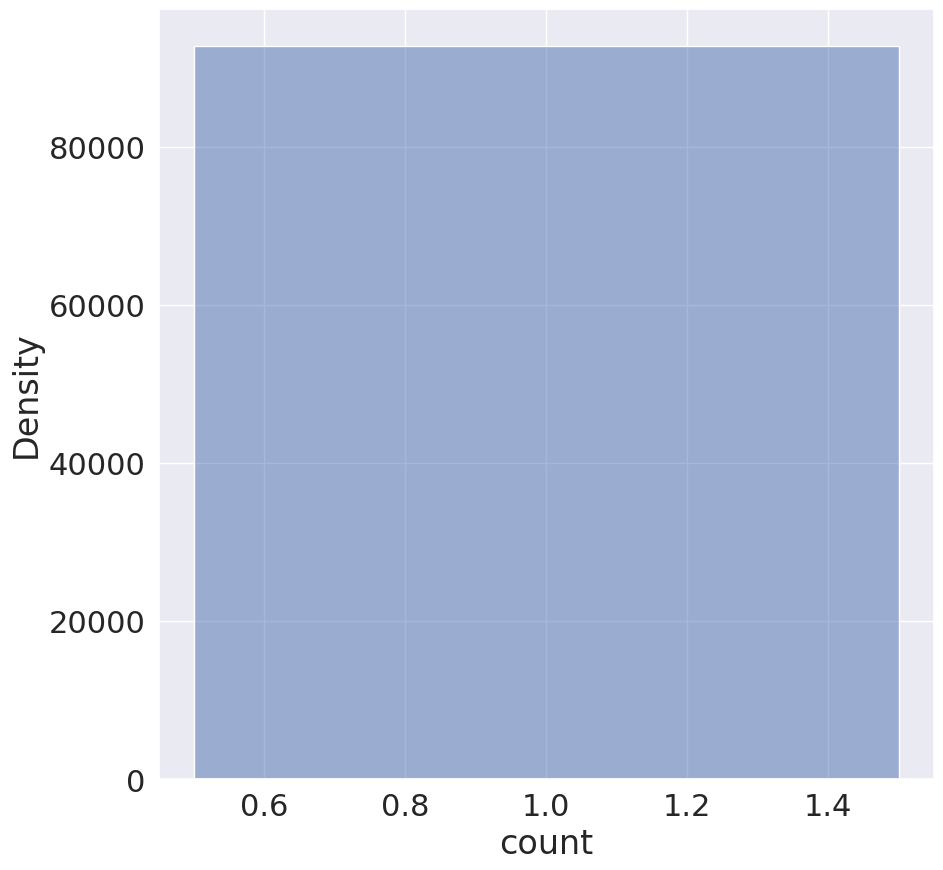

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

view_col = "count"   # e.g. whatever you find from df.columns

# Describe statistics
print(pd.DataFrame(trendingdate_df[view_col].astype(int)).describe())

# Plot
plt.figure(figsize=(10, 10))
sns.set(font_scale=2)
sns.histplot(trendingdate_df[view_col].astype(int), kde=True)
plt.xlabel(view_col)
plt.ylabel("Density")
plt.show()

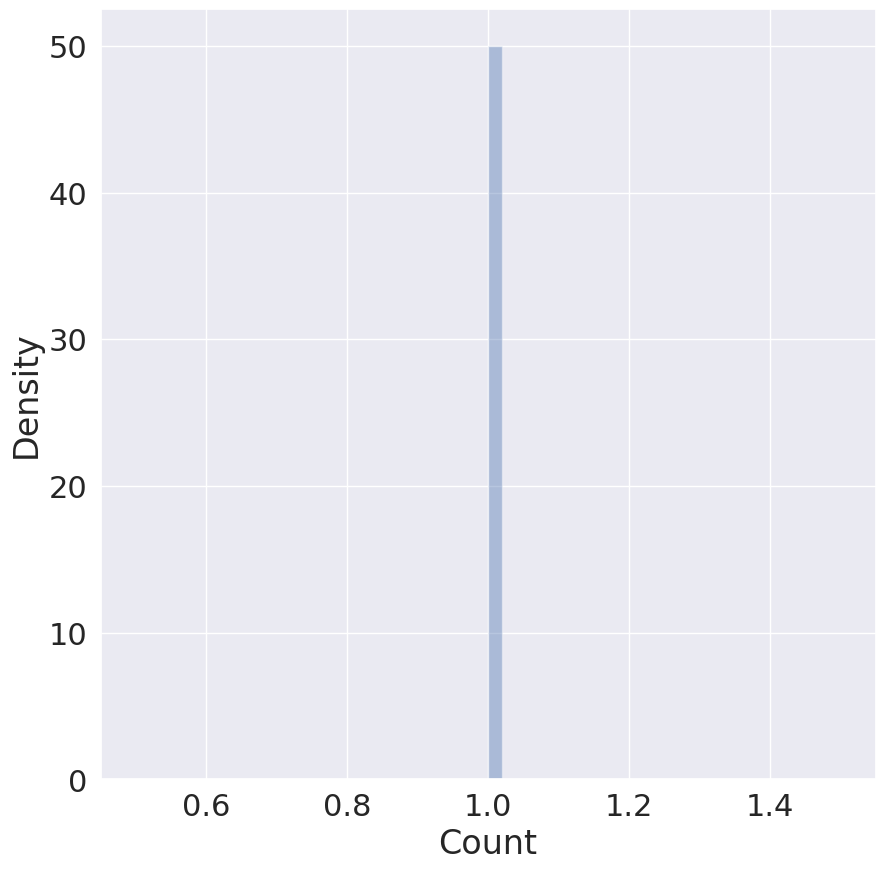

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pd.DataFrame(trendingdate_df["count"].astype('int').copy()).describe()
plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.distplot(trendingdate_df["count"])
plt.xlabel('Count');
plt.ylabel('Density');

In [ ]:
trendingdate_df["count"].mean()

np.float64(1.0)

In [ ]:
videos_df[videos_df["viewCount"].idxmax():videos_df["viewCount"].idxmax()+1]

,kind,videoId,publishedAt,channelId,title,description,tags,defaultLanguage,defaultAudioLanguage,contentDuration,viewCount,likeCount,favouriteCount,commentCount,topicCategories,topic_names,topic_main
42479,youtube#video,14688,2024-01-08 13:23:58+00:00,26428,Korean Secret Glowing Skin Mask | Beauty Secrets| Look Beautiful #shorts,Korean Secret Glowing Skin Mask | Beauty Secrets| Look Beautiful #shorts,NaN,NaN,NaN,PT27S,405748145.0,4102127.0,0,4813.0,"[https://en.wikipedia.org/wiki/Lifestyle_(sociology), https://en.wikipedia.org/wiki/Physical_attractiveness]","[Lifestyle (sociology), Physical attractiveness]",Lifestyle (sociology)


In [ ]:
videos_df[videos_df["viewCount"].idxmin():videos_df["viewCount"].idxmin()+1]

,kind,videoId,publishedAt,channelId,title,description,tags,defaultLanguage,defaultAudioLanguage,contentDuration,viewCount,likeCount,favouriteCount,commentCount,topicCategories,topic_names,topic_main
10,youtube#video,26090,2023-12-19 18:29:16+00:00,11960,Skincare for Rosacea: Managing and Soothing Redness,NaN,NaN,en-US,en-US,PT11S,0.0,0.0,0,0.0,"[https://en.wikipedia.org/wiki/Lifestyle_(sociology), https://en.wikipedia.org/wiki/Physical_attractiveness]","[Lifestyle (sociology), Physical attractiveness]",Lifestyle (sociology)


In [ ]:
corrolation_list = ['viewCount', 'likeCount','commentCount']
hm_data = videos_df[corrolation_list].corr()
display(hm_data)

,viewCount,likeCount,commentCount
viewCount,1.000000,0.856909,0.416684
likeCount,0.856909,1.000000,0.525679
commentCount,0.416684,0.525679,1.000000


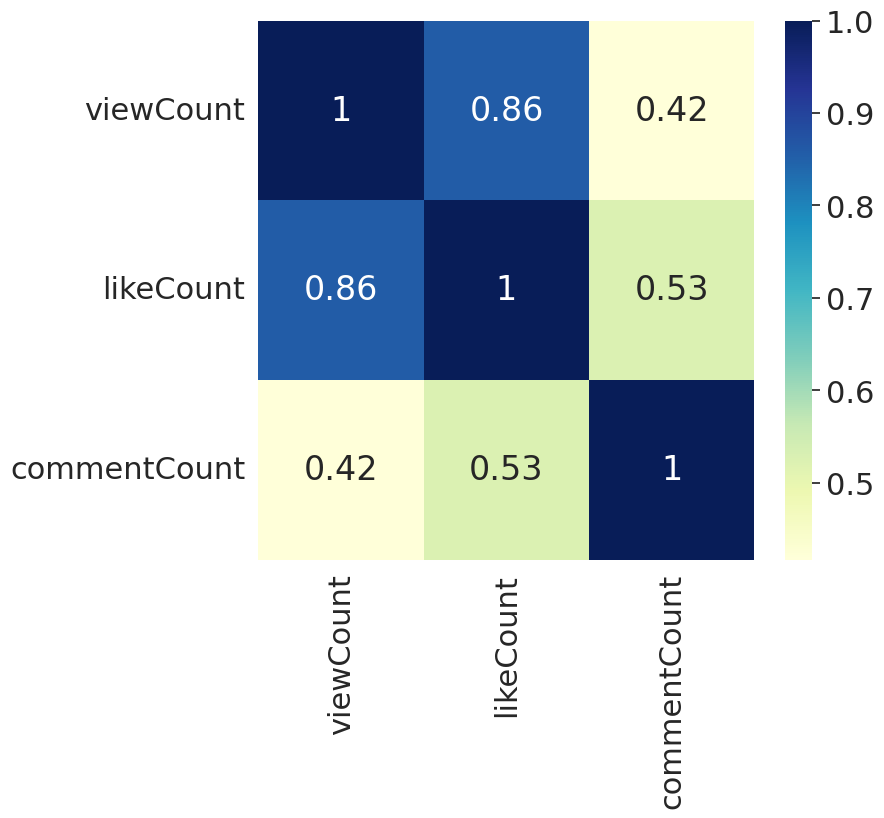

In [ ]:
import matplotlib
import seaborn as sns

matplotlib.pyplot.figure(figsize=(8,7))
sns.set(font_scale=2)
sns.heatmap(hm_data,cmap="YlGnBu", annot=True);

Text(0.5, 1.0, 'Correlation of likeCount and viewCount')

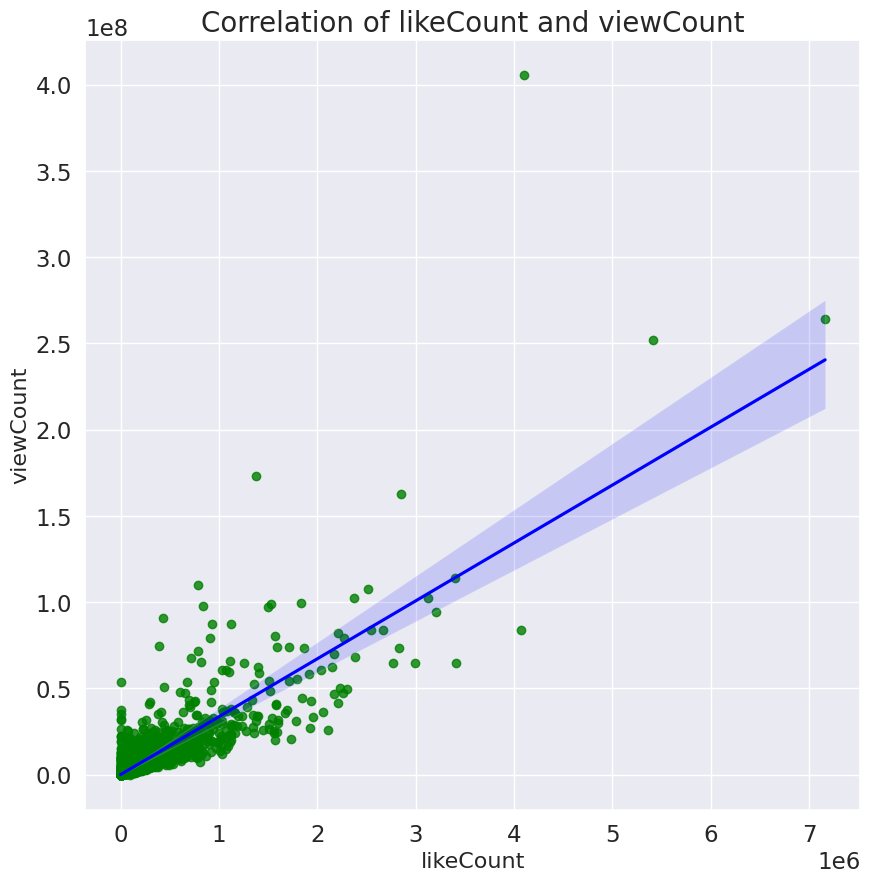

In [ ]:
matplotlib.pyplot.figure(figsize=(10,10))
sns.set(font_scale=1.5)
sns.regplot(x=videos_df['likeCount'], y=videos_df['viewCount'],scatter_kws={"color": "green"}, line_kws={"color": "blue"})
matplotlib.pyplot.xlabel('likeCount', fontsize=16);
matplotlib.pyplot.ylabel('viewCount', fontsize=16);
matplotlib.pyplot.title('Correlation of likeCount and viewCount', fontsize=20)

Text(0.5, 1.0, 'Correlation of Comment count and View count')

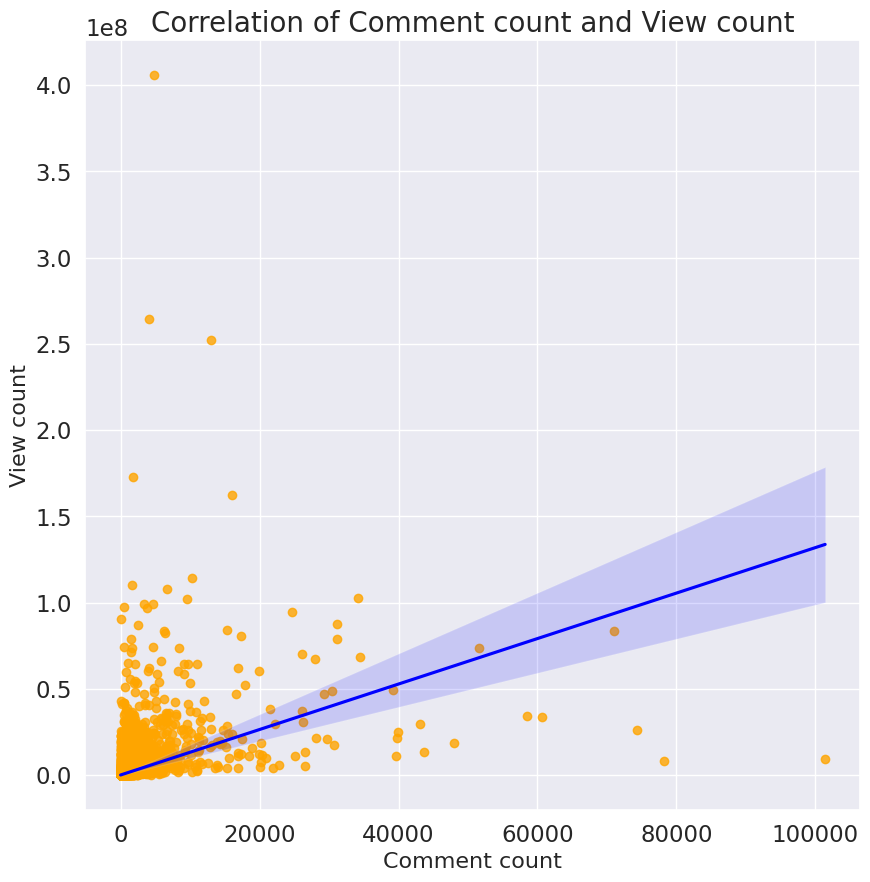

In [ ]:
matplotlib.pyplot.figure(figsize=(10,10))
sns.set(font_scale=1.5)
sns.regplot(x=videos_df['commentCount'], y=videos_df['viewCount'],scatter_kws={"color": "orange"}, line_kws={"color": "blue"})
matplotlib.pyplot.xlabel('Comment count', fontsize=16);
matplotlib.pyplot.ylabel('View count', fontsize=16);
matplotlib.pyplot.title('Correlation of commentCount and viewCount', fontsize=20)

In [ ]:
# --- 1) Parse topicCategories and create readable labels ---
import ast

# turn stringified lists into real lists
videos_df["topicCategories"] = videos_df["topicCategories"].fillna("[]").apply(
    lambda x: x if isinstance(x, list) else ast.literal_eval(str(x))
)
videos_df["topic_names"] = videos_df["topicCategories"].apply(
    lambda urls: [u.split("/")[-1].replace("_", " ") for u in urls]
)

# take the first topic as the primary label
videos_df["topic_main"] = videos_df["topic_names"].apply(lambda lst: lst[0] if lst else None)

# --- 2) Create a numeric category_id from topic_main ---
# (codes are stable within this dataset; if you need cross-run stability, build a fixed mapping)
videos_df["category_id"] = videos_df["topic_main"].astype("category").cat.codes

# lookup table: id -> title
category_id_df = (
    videos_df[["category_id", "topic_main"]]
    .drop_duplicates()
    .rename(columns={"topic_main": "category_title"})
)

US1 = videos_df.merge(category_id_df, how="left", on="category_id")


   channelId  no_of_videos
1      24456           186
2      23036           147
3      16540           136
4      18073           131
5      38751           109


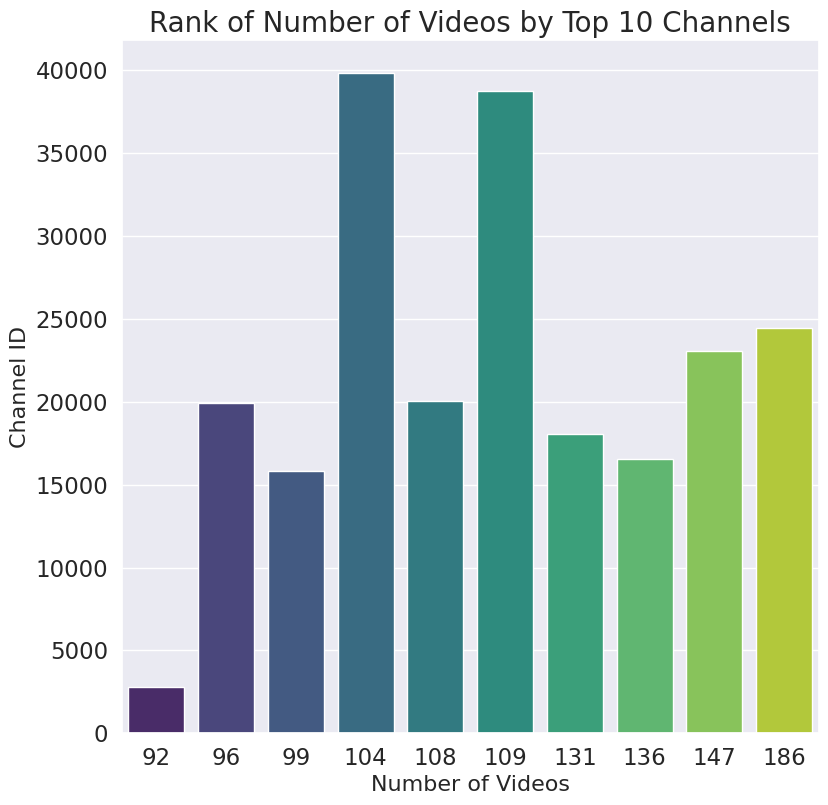

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count videos per channel
top_channels = (
    US1["channelId"].value_counts()
    .head(10)
    .reset_index()
)

# Rename properly
top_channels.columns = ["channelId", "no_of_videos"]

# Make indices 1–10 for ranking
top_channels.index = range(1, 11)

print(top_channels.head())  # 👈 sanity check

# Plot
plt.figure(figsize=(9, 9))
sns.set(font_scale=1.5)
sns.barplot(y="channelId", x="no_of_videos", data=top_channels, palette="viridis")

plt.xlabel("Number of Videos", fontsize=16)
plt.ylabel("Channel ID", fontsize=16)
plt.title("Rank of Number of Videos by Top 10 Channels", fontsize=20)
plt.show()



Text(0.5, 1.0, 'Rank of Number of Video of Category')

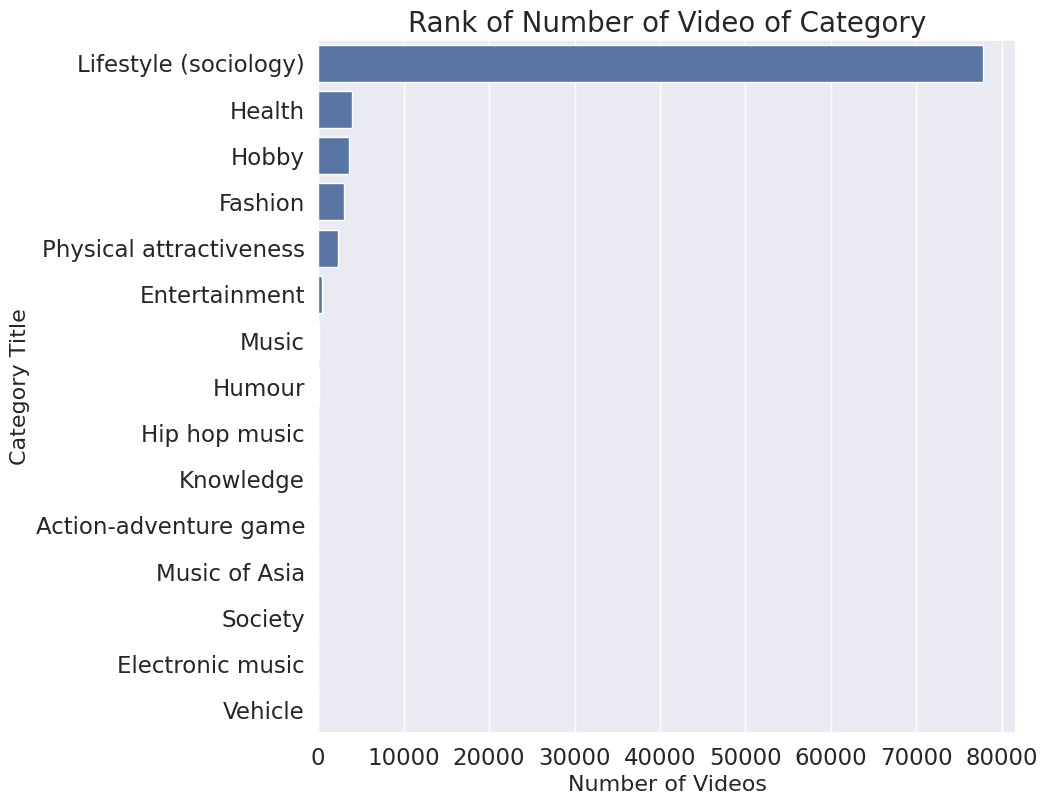

In [ ]:
l=US1.topic_main.value_counts()[:15].index
video_count = pd.DataFrame({'category_title':l,'no_of_videos':US1.topic_main.value_counts()[:15]})
video_count.index=[i for i in range(1,16)]
matplotlib.pyplot.figure(figsize=(9,9))
sns.set(font_scale=1.5)
sns.barplot(x="no_of_videos",y="category_title",data = video_count)
matplotlib.pyplot.xlabel('Number of Videos', fontsize=16);
matplotlib.pyplot.ylabel('Category Title', fontsize=16);
matplotlib.pyplot.title('Rank of Number of Video by Category', fontsize=20)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) pick the correct category column
cat_col = "category_title" if "category_title" in US1.columns else (
          "topic_main" if "topic_main" in US1.columns else None)
if cat_col is None:
    raise KeyError("No category column found. Expected 'category_title' or 'topic_main'.")

# 2) ensure viewCount is numeric and compute millions
US1["viewCount"] = pd.to_numeric(US1["viewCount"], errors="coerce")
US1["Views in million"] = US1["viewCount"] / 1_000_000

# 3) aggregate with named columns (avoids MultiIndex)
agg_df = (
    US1.groupby(cat_col)["Views in million"]
       .agg(mean_views_million="mean", video_count="count")
       .sort_values("video_count", ascending=False)
       .head(15)
       .reset_index()
)

# 4) set a 1..15 rank index
agg_df.index = range(1, len(agg_df) + 1)

# 5) (optional) style the table
cm = sns.light_palette("#a275ac", as_cmap=True)
styled = (agg_df.style
          .background_gradient(cmap=cm, subset=["mean_views_million", "video_count"])
          .format({"mean_views_million": "{:.2f}", "video_count": "{:,}"}))

# display the styled table in notebooks; in scripts, just print(agg_df)
styled


,category_title,mean_views_million,video_count
1,Lifestyle (sociology),0.24,"77,760"
2,Health,0.08,"3,956"
3,Hobby,0.16,"3,550"
4,Fashion,0.29,"2,973"
5,Physical attractiveness,0.03,"2,267"
6,Entertainment,1.17,491
7,Music,0.14,63
8,Humour,0.55,34
9,Hip hop music,0.06,18
10,Knowledge,0.19,16


In [ ]:
import pandas as pd

# 0) Choose the correct ID column name in US1
id_col = "videoId" if "videoId" in US1.columns else ("video_id" if "video_id" in US1.columns else None)
if id_col is None:
    raise KeyError(f"No video id column in US1. Columns: {US1.columns.tolist()}")

# 1) Make sure 'count' is numeric
trendingdate_df["count"] = pd.to_numeric(trendingdate_df["count"], errors="coerce")

# 2) Build the allowlist of video IDs (normalize as strings, strip spaces)
vids = (trendingdate_df.loc[trendingdate_df["count"] == 1, "videoId"]
        .astype(str).str.strip().str.lower().dropna().unique())

# 3) Normalize US1 ids the same way (without losing original)
US1["_vid_norm"] = US1[id_col].astype(str).str.strip().str.lower()

# 4) Check overlap before filtering
overlap = pd.Index(US1["_vid_norm"]).intersection(vids)
print("US1 unique ids:", US1["_vid_norm"].nunique())
print("allowlist ids:", len(vids))
print("intersection:", len(overlap))

# 5) Filter
US2 = US1[US1["_vid_norm"].isin(vids)].copy()
print("US2 shape:", US2.shape)

# 6) If still zero, show a few examples to debug
if US2.empty:
    print("Example ids from US1:", US1["_vid_norm"].head(5).tolist())
    print("Example ids from allowlist:", list(vids[:5]))

# OPTIONAL: drop helper column later
# US2.drop(columns=["_vid_norm"], inplace=True)


US1 unique ids: 92759
allowlist ids: 92759
intersection: 92759
US2 shape: (92759, 21)


In [ ]:
#print(US1["trendingDate"][:5])
US1["published_date_only"]=pd.to_datetime(US1["published_date_only"],format = "%Y.%m.%d")
US1["publish_date"]=pd.to_datetime(US1["publishedAt"]).dt.date

US1["published_hours"]=pd.to_datetime(US1["publishedAt"]).dt.hour
#print(US1["published_hours"][:5])
US1["publish_date"]=pd.to_datetime(US1["publish_date"],format = "%Y/%m/%d")
l=[]
for i in US1["publish_date"]:
    l.append(i.day_name())
US1["publish_day"]= l

In [ ]:
import pandas as pd

# 0) Start from the base dataframe
US1 = videos_df.copy()

# 1) (if not already present) create category titles and IDs as you did before,
#    then merge them back. If you already have category_id_df, just merge:
US1 = US1.merge(category_id_df, how="left", on="category_id")   # category_id_df: [category_id, category_title]

# 2) Build datetime columns from publishedAt (which you DO have)
#    If your dataset uses a different column, change "publishedAt" accordingly.
US1["publishedAt"] = pd.to_datetime(US1["publishedAt"], errors="coerce", utc=True)
US1["publishedAt"] = US1["publishedAt"].dt.tz_convert(None)   # drop timezone to naive

US1["published_date_only"] = US1["publishedAt"].dt.date
US1["published_year"]      = US1["publishedAt"].dt.year
US1["publish_date"]        = US1["publishedAt"].dt.date
US1["published_hours"]     = US1["publishedAt"].dt.hour
US1["publish_day"]         = US1["publishedAt"].dt.day_name()

# If you want a datetime column called trending_date1, base it on publishedAt:
US1["trending_date1"] = US1["publishedAt"].dt.floor("D")

# 3) Now select only the columns that exist (safe slicing)
columns = [
    'kind','videoId','publishedAt','channelId','title','description','tags',
    'defaultLanguage','defaultAudioLanguage','contentDuration','viewCount',
    'likeCount','favouriteCount','commentCount','topicCategories',
    'topic_names','topic_main','category_id','category_title',
    'published_date_only','published_year','publish_date','published_hours',
    'publish_day','trending_date1'
]
existing_cols = [c for c in columns if c in US1.columns]
US1 = US1[existing_cols].copy()   # <-- NO trailing comma


In [ ]:
from sklearn.preprocessing import StandardScaler

def standardize(data):
    scaler = StandardScaler()
    scaler = scaler.fit(data)
    transformed = scaler.transform(data)
    return scaler,transformed
scaler_views, US_views = standardize(US2.viewCount.values.reshape(-1,1))

In [ ]:
import math

mean_view = scaler_views.mean_
mean_view = mean_view[0]
var_view = scaler_views.var_
sqr_view = math.sqrt(var_view)
print(mean_view)
print(sqr_view)

234961.51229642576
3100176.3871488185


In [ ]:
import pandas as pd

# Ensure US2 has trending_date1
if "trending_date1" not in US2.columns:
    if "publishedAt" in US2.columns:
        US2["publishedAt"] = pd.to_datetime(US2["publishedAt"], errors="coerce")
        US2["trending_date1"] = US2["publishedAt"].dt.floor("D")
    else:
        raise KeyError("No suitable date column to build trending_date1")

# Build US3
US3 = pd.DataFrame()
US3["trending_date1"] = US2["trending_date1"]
US3["videoId"] = US2["videoId"]  # ✅ correct column name
US3["views"] = US_views.ravel()  # flatten array from StandardScaler

US3.reset_index(drop=True, inplace=True)
print(US3.head())


             trending_date1  videoId     views
0 2024-01-15 00:00:00+00:00    85806 -0.075766
1 2023-10-27 00:00:00+00:00    30556 -0.075707
2 2024-09-28 00:00:00+00:00    51771 -0.075737
3 2023-07-13 00:00:00+00:00    45298 -0.075400
4 2023-04-29 00:00:00+00:00    43611 -0.073001


In [ ]:
US3.reset_index(drop=True, inplace=True)
print(US3.head())

             trending_date1  videoId     views
0 2024-01-15 00:00:00+00:00    85806 -0.075766
1 2023-10-27 00:00:00+00:00    30556 -0.075707
2 2024-09-28 00:00:00+00:00    51771 -0.075737
3 2023-07-13 00:00:00+00:00    45298 -0.075400
4 2023-04-29 00:00:00+00:00    43611 -0.073001


Text(0.5, 1.0, 'Total daily video releases (Since Aug. 2020 to present)')

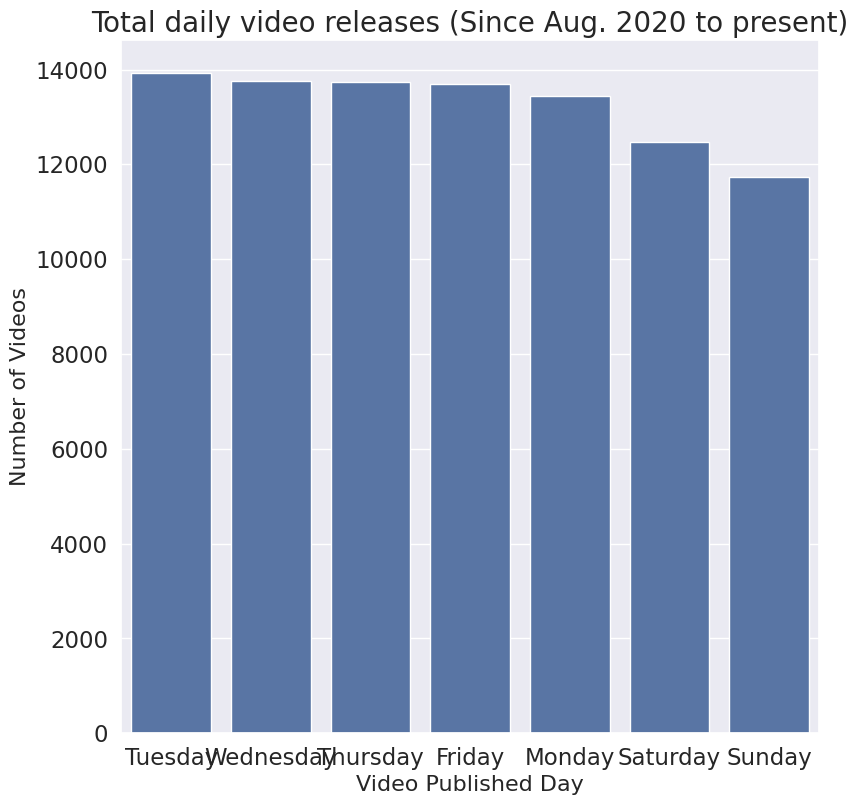

In [ ]:
x=US1["publish_day"].value_counts()
#print(x.index)
published_day=pd.DataFrame({"publish_day":x.index,"no_of_videos":x})
published_day.index=[i for i in range(0,7)]
matplotlib.pyplot.figure(figsize=(9,9))
sns.barplot(x="publish_day",y="no_of_videos",data=published_day)
matplotlib.pyplot.xlabel('Video Published Day', fontsize=16);
matplotlib.pyplot.ylabel('Number of Videos', fontsize=16);
matplotlib.pyplot.title('Total daily video releases (Since Aug. 2020 to present)', fontsize=20)

Text(0.5, 1.0, 'Total Hourly video releases (Since Aug. 2020 to present)')

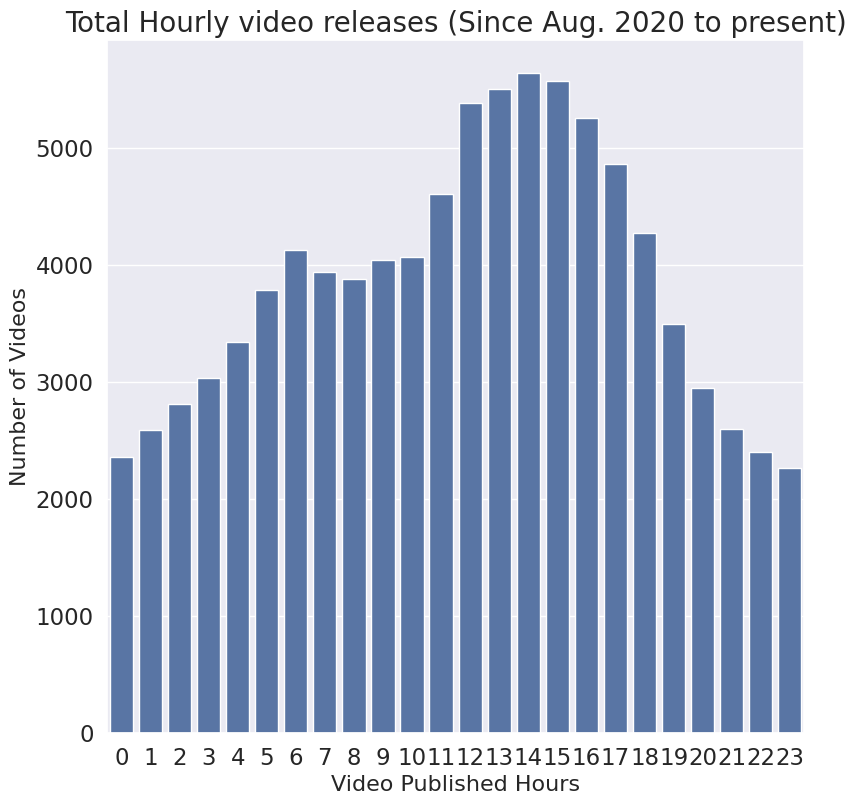

In [ ]:
c=US1["published_hours"].value_counts()
hours=pd.DataFrame({"published_hours":c.index,"numb_of_videos":c})
hours.index=[i for i in range(0,24)]
hours=hours.sort_values("published_hours")
matplotlib.pyplot.figure(figsize=(9,9))
sns.barplot(x="published_hours",y="numb_of_videos",data=hours)
matplotlib.pyplot.xlabel('Video Published Hours', fontsize=16);
matplotlib.pyplot.ylabel('Number of Videos', fontsize=16);
matplotlib.pyplot.title('Total Hourly video releases (Since Aug. 2020 to present)', fontsize=20)

In [ ]:
x=[]
y=[]

videos = US3['videoId'].unique().tolist()

for v in videos:
    row=[]

    temp_df = US3[US3["videoId"]==v].sort_values(by="trending_date1")
    print(f"\n--- Processing video {video_count}: {v} ---")
    print(f"Found {len(temp_df)} records for this video")

    print (temp_df)
    seq = temp_df.views[0:5].index #first 5 views as input

    for s in seq:
        row.append(US3.iloc[s].values[2:])

    x.append(row)
    nextstep = temp_df.views[5:6].values # the last views as output
    y.append(nextstep)



Streaming output truncated to the last 5000 lines.

--- Processing video              category_title  no_of_videos
1     Lifestyle (sociology)         77760
2                    Health          3956
3                     Hobby          3550
4                   Fashion          2973
5   Physical attractiveness          2267
6             Entertainment           491
7                     Music            63
8                    Humour            34
9             Hip hop music            18
10                Knowledge            16
11    Action-adventure game            15
12            Music of Asia            11
13                  Society            10
14         Electronic music             9
15                  Vehicle             7: 45980 ---
Found 1 records for this video
                 trending_date1  videoId     views
92509 2023-02-17 00:00:00+00:00    45980 -0.075577

--- Processing video              category_title  no_of_videos
1     Lifestyle (sociology)         77760
2    

In [ ]:
import numpy as np
import pandas as pd

# ---- x/y must be shaped correctly ----
# Example: ensure x is (n, 1, 1) and y is (n, 1)
x = np.asarray(x)
y = np.asarray(y)

# If x is 1D -> make it (n, 1, 1)
if x.ndim == 1:
    x = x.reshape(-1, 1, 1)
# If x is 2D -> treat as (n, timesteps) -> add features dim
elif x.ndim == 2:
    x = x.reshape(x.shape[0], x.shape[1], 1)

# y should be (n, 1)
if y.ndim == 1:
    y = y.reshape(-1, 1)

print("x shape:", x.shape)  # (n, 1, 1)
print("y shape:", y.shape)  # (n, 1)


x shape: (92759, 1, 1)
y shape: (92759, 0)


In [ ]:
from sklearn.model_selection import ShuffleSplit,train_test_split
x_train,x_testall,y_train,y_testall = train_test_split(x,y,test_size=0.4,random_state=42)
x_val,x_test,y_val,y_test = train_test_split(x_testall,y_testall,test_size=0.5,random_state=42)

In [ ]:
import pandas as pd
import numpy as np

# Ensure types
US1["trending_date1"] = pd.to_datetime(US1["trending_date1"], errors="coerce")
US1["viewCount"] = pd.to_numeric(US1["viewCount"], errors="coerce")

# --- 1) Diagnose per-video days ---
days_per_video = (US1
    .assign(day=US1["trending_date1"].dt.date)
    .groupby("videoId")["day"].nunique()
    .sort_values(ascending=False))
print("Per-video days summary:\n", days_per_video.describe())
print("Videos with ≥2 days:", int((days_per_video >= 2).sum()))

# --- 2) Build daily per-channel (sums views per day per channel) ---
daily_ch = (US1
    .assign(day=US1["trending_date1"].dt.floor("D"))
    .groupby(["channelId","day"], as_index=False)
    .agg(viewCount=("viewCount","sum")))   # or "max"/"mean" depending on your intent

# Helper: window=1, horizon=1 (next-day forecasting)
def make_window1_nextday(df, group_col, time_col="day", value_col="viewCount"):
    X_list, y_list = [], []
    for _, g in df.groupby(group_col):
        g = g.sort_values(time_col)
        vals = g[value_col].to_numpy(dtype=float)
        if len(vals) < 2:
            continue
        X_list.append(vals[:-1].reshape(-1,1,1))  # (n-1, 1, 1)
        y_list.append(vals[1:].reshape(-1,1))     # (n-1, 1)
    if not X_list:
        return np.empty((0,1,1)), np.empty((0,1))
    return np.concatenate(X_list), np.concatenate(y_list)

# --- 3) Try building sequences per channel ---
X, y = make_window1_nextday(daily_ch, group_col="channelId")
print("Channel sequences -> X:", X.shape, "| y:", y.shape)

# --- 4) Fallback: same-day samples (not forecasting) if still empty ---
def make_window1_same_day(df, group_col, time_col="day", value_col="viewCount"):
    g = df[[group_col, time_col, value_col]].dropna().copy()
    g = g.sort_values([group_col, time_col])
    vals = g[value_col].to_numpy(dtype=float)
    if len(vals) == 0:
        return np.empty((0,1,1)), np.empty((0,1))
    X = vals.reshape(-1,1,1)  # (n, 1, 1)
    y = vals.reshape(-1,1)    # (n, 1)
    return X, y

if X.shape[0] == 0:
    print("No next-day sequences per channel; falling back to same-day samples.")
    X, y = make_window1_same_day(daily_ch, group_col="channelId")
    print("Same-day -> X:", X.shape, "| y:", y.shape)

# --- 5) Train/Val split ---
n = X.shape[0]
if n == 0:
    raise RuntimeError("Still no samples. Consider aggregating by category_title/topic_main instead of channelId.")

split = int(0.8*n)
x_train, x_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]
print("Train:", x_train.shape, y_train.shape, "| Val:", x_val.shape, y_val.shape)


Per-video days summary:
 count    92759.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: day, dtype: float64
Videos with ≥2 days: 0
Channel sequences -> X: (35851, 1, 1) | y: (35851, 1)
Train: (28680, 1, 1) (28680, 1) | Val: (7171, 1, 1) (7171, 1)


Epoch 1/50
444/449 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 21635929210880.0000 - mae: 422017.9062
Epoch 1: val_loss improved from inf to 21503900909568.00000, saving model to view_count_predict.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 21505566048256.0000 - mae: 421366.2500 - val_loss: 21503900909568.0000 - val_mae: 459951.9062
Epoch 2/50
435/449 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14301810130944.0000 - mae: 390716.9375
Epoch 2: val_loss did not improve from 21503900909568.00000
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14213458165760.0000 - mae: 390126.6250 - val_loss: 23475529973760.0000 - val_mae: 472659.6562
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12285651189760.0000 - mae: 371003.2812
Epoch 3: val_loss improved from 21503900909568.00000 to 20914341150720.00000, saving model to view_count_predict.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12283992342528.0000 - mae: 371000.0625 - val_loss: 20914341150720.0000 - val_mae: 46752

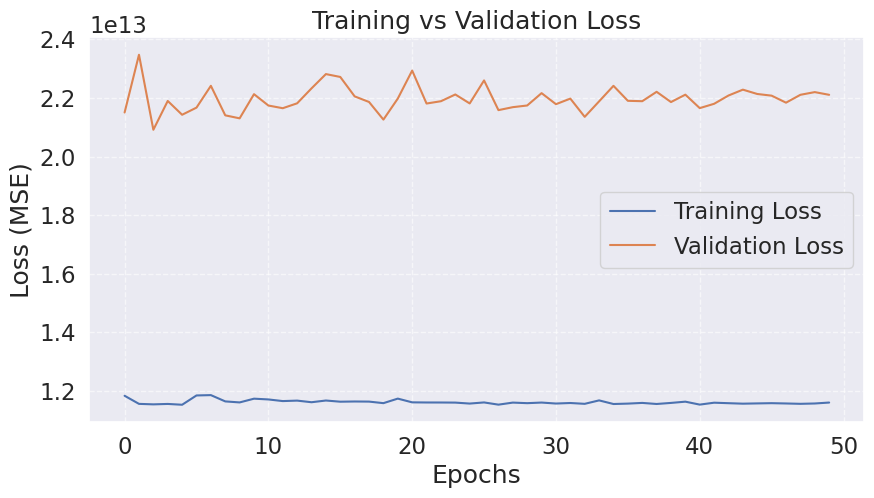

In [ ]:
import tensorflow_hub

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

# 1. Build the model
model = Sequential([
    Dense(64, activation="relu", input_shape=(x_train.shape[1],)),  # input layer
    Dense(32, activation="relu"),
    Dense(1)  # output layer (for regression)
])

# --- Define checkpoint callback ---
checkpointer = ModelCheckpoint(
    filepath="view_count_predict.keras",
    verbose=1,
    save_best_only=True
)

model.compile(
    optimizer="adam",            # good default optimizer
    loss="mse",                  # mean squared error (for regression)
    metrics=["mae"]              # mean absolute error (optional metric)
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50, batch_size=64,
    callbacks=[checkpointer],
    verbose=1
)

loss = history.history.get("loss", [])
val_loss = history.history.get("val_loss", [])

epochs_range = range(len(loss))

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, loss, label="Training Loss")
if len(val_loss) > 0:
    plt.plot(epochs_range, val_loss, label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,725 (26.27 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,484 (17.52 KB)

In [ ]:
print("x_train", x_train.shape, "dtype", x_train.dtype)
print("y_train", y_train.shape, "dtype", y_train.dtype)

# enforce correct shape
if x_train.ndim == 1:
    x_train = x_train.reshape(-1, 1, 1)
elif x_train.ndim == 2:
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

if y_train.ndim == 1:
    y_train = y_train.reshape(-1, 1)


x_train (28680, 1, 1) dtype float64
y_train (28680, 1) dtype float64


In [ ]:
import numpy as np, math
from sklearn.metrics import mean_squared_error

# 1) Basic sanity: reuse val as test if needed
if "x_test" not in globals() or x_test is None or getattr(x_test, "size", 0) == 0:
    x_test, y_test = x_val, y_val

# 2) Ensure proper shapes/dtypes (LSTM expects x: (n,1,1), y: (n,1))
def fix_x(x):
    x = np.asarray(x)
    if x.ndim == 1:  x = x.reshape(-1, 1, 1)
    elif x.ndim == 2: x = x.reshape(x.shape[0], x.shape[1], 1)
    return x.astype("float64", copy=False)

def fix_y(y):
    y = np.asarray(y)
    if y.ndim == 1: y = y.reshape(-1, 1)
    return y.astype("float64", copy=False)

x_train = fix_x(x_train); y_train = fix_y(y_train)
x_test  = fix_x(x_test);  y_test  = fix_y(y_test)

# 3) Predict
pred_train = model.predict(x_train, verbose=0)
pred_test  = model.predict(x_test,  verbose=0)

# 4) Diagnose length mismatch
n_pred_tr, n_true_tr = len(pred_train), len(y_train)
n_pred_te, n_true_te = len(pred_test), len(y_test)
print(f"train lens -> pred:{n_pred_tr}  true:{n_true_tr}")
print(f"test  lens -> pred:{n_pred_te}  true:{n_true_te}")

# 5) Hard align lengths (trim to the minimum) to avoid the ValueError
if n_pred_tr != n_true_tr:
    n = min(n_pred_tr, n_true_tr)
    pred_train = pred_train[:n]
    y_train    = y_train[:n]
if n_pred_te != n_true_te:
    n = min(n_pred_te, n_true_te)
    pred_test = pred_test[:n]
    y_test    = y_test[:n]

# 6) Compute RMSE
train_rmse = math.sqrt(mean_squared_error(y_train, pred_train))
test_rmse  = math.sqrt(mean_squared_error(y_test,  pred_test))
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test  RMSE: {test_rmse:.4f}")

# 7) Naive baseline (window=1): y_hat_{t+1} = y_t
x_test_flat = x_test.reshape(x_test.shape[0], -1)  # (n,1)
naive_rmse  = math.sqrt(mean_squared_error(y_test, x_test_flat))
print(f"Naive RMSE: {naive_rmse:.4f}")

# 8) Quick demo rows
for i in range(min(10, len(pred_test))):
    print(f"{i:3d} | pred={pred_test[i,0]:.2f} | input_t={x_test_flat[i,0]:.2f} | true={y_test[i,0]:.2f}")


train lens -> pred:28680  true:28680
test  lens -> pred:18552  true:18552


ValueError: Found array with 0 feature(s) (shape=(18552, 0)) while a minimum of 1 is required.

In [ ]:
def view_performance():
    return trainScore,valScore,predict.astype('int')[0:10],x_test_rev.astype('int')[0:10], y_test.astype('int')[0:10]
    print('Train Score: %.2f RMSE' % (trainScore))
    print('Val Score: %.2f RMSE' % (valScore))
    print ("the demo predict is %s" %(predict.astype('int')[0:10]))
    print ("the demo train is %s" %(x_test_rev.astype('int')[0:10]))
    print ("the demo true is %s" %(y_test.astype('int')[0:10]))

In [ ]:
scaler_likes, US_likes = standardize(US2.likeCount.values.reshape(-1,1))
scaler_comment_count, US_comment_count = standardize(US2.commentCount.values.reshape(-1,1))

In [ ]:
mean_likes = scaler_likes.mean_
mean_comment_count = scaler_comment_count.mean_
mean_likes = mean_likes[0]
mean_comment_count = mean_comment_count[0]

var_likes = scaler_likes.var_
var_comment_count = scaler_comment_count.var_
sd_likes = math.sqrt(var_likes)
sd_comment_count = math.sqrt(var_comment_count)

In [ ]:
US4 = pd.DataFrame()
US4["trending_date1"] = US2["trending_date1"]
US4["videoId"] = US2["videoId"]
US4["views"] = US_views
US4["likeCount"] = US_likes
US4["comment_count"] = US_comment_count

In [ ]:
US4

,trending_date1,videoId,views,likeCount,comment_count
0,2024-01-15 00:00:00+00:00,85806,-0.075766,-0.089502,-0.067095
1,2023-10-27 00:00:00+00:00,30556,-0.075707,-0.089413,-0.067095
2,2024-09-28 00:00:00+00:00,51771,-0.075737,-0.089451,-0.065055
3,2023-07-13 00:00:00+00:00,45298,-0.075400,-0.089249,-0.067095
4,2023-04-29 00:00:00+00:00,43611,-0.073001,-0.086115,-0.059953
...,...,...,...,...,...
92754,2023-12-28 00:00:00+00:00,26001,-0.075311,-0.089135,-0.067095
92755,2021-04-15 00:00:00+00:00,34584,-0.075782,-0.089451,-0.067095
92756,2023-04-27 00:00:00+00:00,21075,-0.075331,-0.089375,-0.064034
92757,2025-04-27 00:00:00+00:00,44523,-0.075766,-0.089489,-0.067095


In [ ]:
x_four=[]
y_four=[]
for v in videos:
    row=[]
    temp_df = US3[US3["videoId"]==v].sort_values(by="trending_date1")

    seq = temp_df.views[0:5].index #first 5 views as input
    #print seq
    #print(seq)
    for s in seq:
        #print (US3.iloc[s].values[2:])
        row.append(US4.iloc[s].values[2:])
    #print(row)

    x_four.append(row)
    nextstep = temp_df.views[5:6].values # the last views as output
    y_four.append(nextstep)

In [ ]:
x_four = np.reshape(x_four,(len(x_four),20,1)) # new
#print (x.shape)
y_four = np.reshape(y_four,(-1,1))
#print (y.shape)
x_four = x_four.astype('float64')
y_four = y_four.astype('float64')
#print(x_four)

ValueError: cannot reshape array of size 278277 into shape (92759,20,1)

In [ ]:
x_train_new,x_testall_new,y_train_new,y_testall_new = train_test_split(x_four,y_four,test_size=0.4,random_state=42)
x_val_new,x_test_new,y_val_new,y_test_new = train_test_split(x_testall_new,y_testall_new,test_size=0.5,random_state=42)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint

# =========================
# 1) Load your DataFrame
# =========================
# Example: replace with your file
# df = pd.read_csv("youtube_data.csv")
# Must contain columns: "viewCount", "likeCount", "dislikeCount", "commentCount"

# For illustration (remove this block if you load a real CSV)
df = pd.DataFrame({
    "viewCount":   np.arange(200) + 100,
    "likeCount":   np.random.randint(10, 50, size=200),
    "commentCount":np.random.randint(1, 20, size=200)
})

# =========================
# 2) Features & target
# =========================
feature_cols = ["viewCount", "likeCount", "commentCount"]
target_col   = "viewCount"   # predict future views

features = df[feature_cols].to_numpy(dtype="float32")    # (T, F)
target_series = df[target_col].to_numpy(dtype="float32") # (T,)

# Optional: scale features (not target, so you can interpret predictions)
scaler_X = StandardScaler()
features_scaled = scaler_X.fit_transform(features)

# =========================
# 3) Windowing function
# =========================
def make_windows_multivar(X, y, lookback=20, horizon=1):
    """
    X: (T, F)
    y: (T,)
    -> X_out: (N, lookback, F), y_out: (N,)
    """
    X = np.asarray(X)
    y = np.asarray(y).reshape(-1)
    T, F = X.shape
    N = T - lookback - horizon + 1
    if N <= 0:
        raise ValueError(f"Not enough rows: T={T}, lookback={lookback}, horizon={horizon}")
    X_out = np.empty((N, lookback, F), dtype=X.dtype)
    for i in range(N):
        X_out[i] = X[i:i+lookback, :]
    y_out = y[lookback + horizon - 1 : lookback + horizon - 1 + N]
    return X_out, y_out

lookback = 20
horizon  = 1
x_all, y_all = make_windows_multivar(features_scaled, target_series, lookback, horizon)

print("All data shapes:", x_all.shape, y_all.shape)  # (N, 20, F), (N,)

# =========================
# 4) Train/val split
# =========================
split = int(0.8 * x_all.shape[0])
x_train_new, y_train_new = x_all[:split], y_all[:split]
x_val_new,   y_val_new   = x_all[split:], y_all[split:]

print("Train:", x_train_new.shape, y_train_new.shape)
print("Val:  ", x_val_new.shape,   y_val_new.shape)

# =========================
# 5) LSTM model
# =========================
num_features = x_train_new.shape[2]

model_new = Sequential([
    LSTM(64, return_sequences=True, input_shape=(lookback, num_features), activation='tanh'),
    Dropout(0.2),
    LSTM(128, return_sequences=False, activation='tanh'),
    Dense(1, activation='linear')
])

model_new.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=0.005))

# =========================
# 6) Checkpoint
# =========================
ckpt_path = 'view_count_multifeature_future.keras'
checkpointer = ModelCheckpoint(
    filepath=ckpt_path,
    verbose=1,
    save_best_only=True,
    save_weights_only=False  # save the full model (Keras 3 format)
)

# =========================
# 7) Train
# =========================
history = model_new.fit(
    x_train_new, y_train_new,
    validation_data=(x_val_new, y_val_new),
    epochs=50, batch_size=64,
    callbacks=[checkpointer],
    verbose=1
)

# =========================
# 8) Load best model
# =========================
best_model = load_model(ckpt_path)

# Make a quick prediction
pred = best_model.predict(x_val_new[:5])
print("Sample predictions:", pred.reshape(-1))


All data shapes: (180, 20, 3) (180,)
Train: (144, 20, 3) (144,)
Val:   (36, 20, 3) (36,)
Epoch 1/50
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 39150.6250
Epoch 1: val_loss improved from inf to 72348.28906, saving model to view_count_multifeature_future.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 38481.0117 - val_loss: 72348.2891
Epoch 2/50
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 32467.9922
Epoch 2: val_loss improved from 72348.28906 to 69733.09375, saving model to view_count_multifeature_future.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 32817.0703 - val_loss: 69733.0938
Epoch 3/50
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 31093.6289 
Epoch 3: val_loss improved from 69733.09375 to 68273.14844, saving model to view_count_multifeature_future.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 31408.5078 - val_loss: 68273.1484
Epoch 4/50
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 30554.3359
Epoch 4: val_loss improved from 68273.14844 to 66769.89062, savi

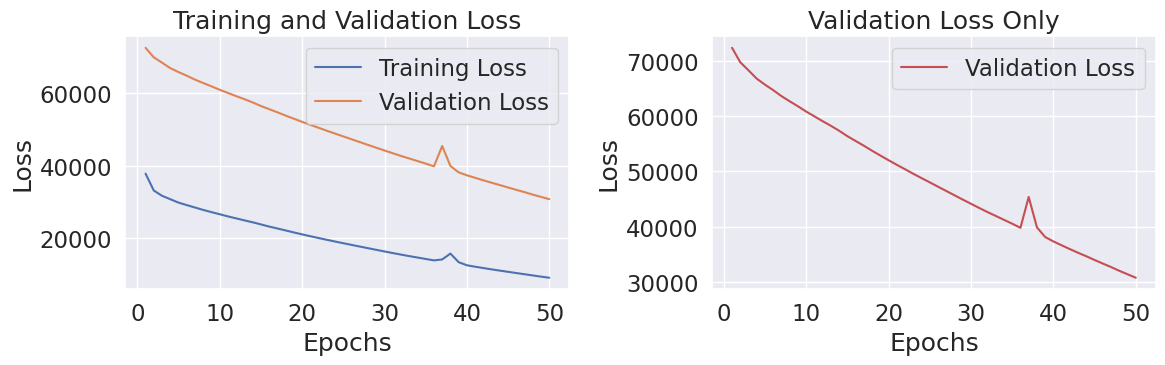

In [ ]:
import matplotlib.pyplot as plt

loss_new = history.history['loss']
val_loss_new = history.history['val_loss']
epochs_range = range(1, len(loss_new) + 1)

plt.figure(figsize=(12, 4))

# Training vs validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss_new, label='Training Loss')
plt.plot(epochs_range, val_loss_new, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Optional: plot only validation loss separately
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss_new, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss Only')

plt.tight_layout()
plt.show()


In [ ]:
def transfer_x_test(x_test_new):
    y_test_new = x_test_new[0:10]
    #print(y_test_new)
    y_test_view=[]
    y_test_like=[]
    y_test_dislike=[]
    y_test_comment=[]
    for j in range(0,10):
        for i in range(0,20,4):
            y_test_view.append(y_test_new[j][i][0])
        #print(y_test_view)
        for i in range(1,20,4):
            y_test_like.append(y_test_new[j][i][0])
        for i in range(2,20,4):
            y_test_dislike.append(y_test_new[j][i][0])
        for i in range(3,20,4):
            y_test_comment.append(y_test_new[j][i][0])
    return y_test_view, y_test_like,  y_test_dislike,y_test_comment

In [ ]:
# =========================
# Multivariate LSTM — Full Code
# =========================

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import math

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint


# ----------------------------------------------------
# 0) Have a DataFrame `df` with your time-ordered rows
# ----------------------------------------------------
# If you already have df, comment out the synthetic example below.
# Synthetic example (delete this block in your real code):
# df = pd.DataFrame({
#     "viewCount":   np.arange(500) + 1000,
#     "likeCount":   np.random.randint(50, 150, size=500),
#     "dislikeCount":np.random.randint(0, 10, size=500),
#     "commentCount":np.random.randint(5, 60, size=500)
# })

# Ensure df exists:
try:
    df
except NameError:
    raise NameError(
        "Please define your pandas DataFrame `df` before running. "
        "It must contain your feature and target columns."
    )

# If your DataFrame is not guaranteed sorted by time, sort it now (edit key as needed):
# df = df.sort_values('timestamp_column').reset_index(drop=True)


# ----------------------------------------------------
# 1) Choose features & target
# ----------------------------------------------------
feature_cols = ["viewCount", "likeCount", "dislikeCount", "commentCount"]  # <-- EDIT if needed
target_col   = "viewCount"  # predict future views (edit if you want a different target)

# Basic validation
for c in feature_cols + [target_col]:
    if c not in df.columns:
        raise ValueError(f"Column '{c}' not found in df. Available: {list(df.columns)}")

features = df[feature_cols].to_numpy(dtype="float32")    # (T, F)
target_series = df[target_col].to_numpy(dtype="float32") # (T,)

# ----------------------------------------------------
# 2) Scale FEATURES (not target)
# ----------------------------------------------------
scaler_X = StandardScaler()
features_scaled = scaler_X.fit_transform(features)

# If you also want to scale the TARGET, uncomment this block and use *_scaled instead.
# (Remember to inverse_transform with a separate scaler for y when evaluating.)
# from sklearn.preprocessing import StandardScaler
# scaler_y = StandardScaler()
# target_scaled = scaler_y.fit_transform(target_series.reshape(-1,1)).reshape(-1)
# USE `target_scaled` INSTEAD OF `target_series` BELOW IF YOU ENABLE THIS.


# ----------------------------------------------------
# 3) Windowing: build (N, lookback, F) and (N,)
# ----------------------------------------------------
def make_windows_multivar(X, y, lookback=20, horizon=1):
    """
    X: (T, F) features
    y: (T,)  target
    Returns:
        X_out: (N, lookback, F)
        y_out: (N,)
    """
    X = np.asarray(X)
    y = np.asarray(y).reshape(-1)
    T, F = X.shape
    N = T - lookback - horizon + 1
    if N <= 0:
        raise ValueError(f"Not enough rows: T={T}, lookback={lookback}, horizon={horizon}")
    X_out = np.empty((N, lookback, F), dtype=X.dtype)
    for i in range(N):
        X_out[i] = X[i:i+lookback, :]
    y_out = y[lookback + horizon - 1 : lookback + horizon - 1 + N]
    return X_out, y_out

lookback = 20   # timesteps fed into the LSTM
horizon  = 1    # predict 1 step ahead
x_all, y_all = make_windows_multivar(features_scaled, target_series, lookback, horizon)
print("All data shapes:", x_all.shape, y_all.shape)  # (N, 20, F), (N,)


# ----------------------------------------------------
# 4) Train/Val split (time-based, no shuffle)
# ----------------------------------------------------
split = int(0.8 * x_all.shape[0])
x_train_new, y_train_new = x_all[:split], y_all[:split]
x_val_new,   y_val_new   = x_all[split:], y_all[split:]

print("Train shapes:", x_train_new.shape, y_train_new.shape)
print("Val shapes:  ", x_val_new.shape,   y_val_new.shape)

# Sanity checks
assert x_train_new.shape[1] == lookback
assert x_train_new.shape[2] == len(feature_cols)
assert y_train_new.ndim == 1
assert x_val_new.shape[0] > 0 and y_val_new.shape[0] > 0


# ----------------------------------------------------
# 5) Model
# ----------------------------------------------------
num_features = x_train_new.shape[2]

model_new = Sequential([
    LSTM(64, return_sequences=True, input_shape=(lookback, num_features), activation='tanh'),
    Dropout(0.2),
    LSTM(128, return_sequences=False, activation='tanh'),
    Dense(1, activation='linear')
])

optimizer = RMSprop(learning_rate=0.005)
model_new.compile(loss='mean_squared_error', optimizer=optimizer)
model_new.summary()


# ----------------------------------------------------
# 6) Checkpoint (.keras full model, Keras 3 format)
# ----------------------------------------------------
ckpt_path = 'view_count_multifeature_future.keras'
checkpointer = ModelCheckpoint(
    filepath=ckpt_path,
    verbose=1,
    save_best_only=True,
    save_weights_only=False
)


# ----------------------------------------------------
# 7) Train
# ----------------------------------------------------
history = model_new.fit(
    x_train_new, y_train_new,
    validation_data=(x_val_new, y_val_new),
    epochs=50, batch_size=64,
    callbacks=[checkpointer],
    verbose=1
)

# Reload best model
best_model = load_model(ckpt_path)


# ----------------------------------------------------
# 8) Plot Training Curves
# ----------------------------------------------------
loss_new = history.history.get('loss', [])
val_loss_new = history.history.get('val_loss', [])
epochs_range = range(1, len(loss_new) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs_range, loss_new, label='Training Loss')
plt.plot(epochs_range, val_loss_new, label='Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title('Training vs Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()


# ----------------------------------------------------
# 9) Evaluation (no inverse needed since y was not scaled)
# ----------------------------------------------------
pred_train = best_model.predict(x_train_new).reshape(-1)
pred_val   = best_model.predict(x_val_new).reshape(-1)

rmse_train = math.sqrt(mean_squared_error(y_train_new, pred_train))
rmse_val   = math.sqrt(mean_squared_error(y_val_new,   pred_val))
mae_train  = mean_absolute_error(y_train_new, pred_train)
mae_val    = mean_absolute_error(y_val_new,   pred_val)
r2_train   = r2_score(y_train_new, pred_train)
r2_val     = r2_score(y_val_new,   pred_val)

print(f"Train: RMSE={rmse_train:.3f}  MAE={mae_train:.3f}  R^2={r2_train:.3f}")
print(f"Val:   RMSE={rmse_val:.3f}  MAE={mae_val:.3f}  R^2={r2_val:.3f}")

# Peek at first 5 validation predictions vs truth
n_show = min(5, len(pred_val))
print("\nVal predictions vs truth (first 5):")
for i in range(n_show):
    print(f"  pred={pred_val[i]:.2f}  true={y_val_new[i]:.2f}")


# ----------------------------------------------------
# 10) (Optional) Inspect an original-scale feature window
# ----------------------------------------------------
# For example, examine the last validation window:
sample = -1  # choose any index in [0, len(x_val_new)-1]
window_scaled = x_val_new[sample]                         # (lookback, F)
window_unscaled = scaler_X.inverse_transform(window_scaled)  # (lookback, F)

# Unpack features in original scale
# Order corresponds to feature_cols
for j, name in enumerate(feature_cols):
    series_last5 = window_unscaled[:, j][-5:].astype(int)
    print(f"{name} (last 5 steps in the window): {series_last5}")

# If you scaled the target earlier (commented section), remember to inverse_transform:
# pred_val_inv = scaler_y.inverse_transform(pred_val.reshape(-1,1)).reshape(-1)
# y_val_inv    = scaler_y.inverse_transform(y_val_new.reshape(-1,1)).reshape(-1)
# ...then compute metrics with pred_val_inv vs y_val_inv


ValueError: Column 'dislikeCount' not found in df. Available: ['viewCount', 'likeCount', 'commentCount']

In [ ]:
def plus_view_performance():
    return trainScore_new,valScore_new,predict_new.astype('int')[0:5], y_test_new.astype('int')[0:5],view_new .astype('int')[0:5],like_new.astype('int')[0:5], dislike_new.astype('int')[0:5], comment_count_new .astype('int')[0:5]


In [ ]:
model_new.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,708 (909.02 KB)

 Trainable params: 116,353 (454.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 116,355 (454.52 KB)

In [ ]:
def predict_fifth_day_by_view_count(input_day_1,input_day_2,input_day_3,input_day_4,input_day_5):
    #print(input_day_1)
    #print(type(input_day_1))
    data = []
    #need to standardlized first
    #ddd = (input_day_1-mean_view)/sqr_view #ddd is an array???????
    data.append([(input_day_1-mean_view)/sqr_view])
    data.append([(input_day_2-mean_view)/sqr_view])
    data.append([(input_day_3-mean_view)/sqr_view])
    data.append([(input_day_4-mean_view)/sqr_view])
    data.append([(input_day_5-mean_view)/sqr_view])
    #data.append([d6])
    print("this is sd data.")
    print(data)
    predict_data = model.predict([data])
    print("this is sd predict data")
    print(predict_data)
    predict_data = (predict_data*sqr_view)+mean_view
    return predict_data.astype('int')

In [ ]:
#(input_day_1-mean_view)/sqr_view     ++ mean_likes, mean_dislikes, mean_comment_count, sd_likes,sd_dislikes,sd_comment_count
# view, like,dislike,coumment_count
def predict_fifth_day_by_view_count_plus_others(a1,a2,a3,a4,a5,b1,b2,b3,b4,b5,c1,c2,c3,c4,c5,d1,d2,d3,d4,d5):
    data1 = [(a1-mean_view)/sqr_view],[(b1-mean_likes)/sd_likes],[(c1-mean_dislikes)/sd_dislikes],[(d1-mean_comment_count)/sd_comment_count]
    data2 = [(a2-mean_view)/sqr_view],[(b2-mean_likes)/sd_likes],[(c2-mean_dislikes)/sd_dislikes],[(d2-mean_comment_count)/sd_comment_count]
    data3 = [(a3-mean_view)/sqr_view],[(b3-mean_likes)/sd_likes],[(c3-mean_dislikes)/sd_dislikes],[(d3-mean_comment_count)/sd_comment_count]
    data4 = [(a4-mean_view)/sqr_view],[(b4-mean_likes)/sd_likes],[(c4-mean_dislikes)/sd_dislikes],[(d4-mean_comment_count)/sd_comment_count]
    data5 = [(a5-mean_view)/sqr_view],[(b5-mean_likes)/sd_likes],[(c5-mean_dislikes)/sd_dislikes],[(d5-mean_comment_count)/sd_comment_count]
    input_data = []
    for i in range(0,4):
        input_data.append(data1[i])
    for i in range(0,4):
        input_data.append(data2[i])
    for i in range(0,4):
        input_data.append(data3[i])
    for i in range(0,4):
        input_data.append(data4[i])
    for i in range(0,4):
        input_data.append(data5[i])
    print(input_data)
    predict_data = model_new.predict([input_data])
    print(predict_data)
    predict_data = (predict_data*sqr_view)+mean_view
    return predict_data